In [1]:
import re
import string
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score
import pandas as pd
import nltk
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from scipy.special import softmax
from datasets import Dataset
import torch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.data.path.append('NLP\\datasets\\customer_reviews.csv')
nltk.download('punkt_tab', download_dir='NLP\\datasets\\customer_reviews.csv')
import matplotlib.pyplot as plt

C:\Users\apoor\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apoor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     NLP\datasets\customer_reviews.csv...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [2]:
db = pd.read_csv('datasets/customer_reviews.csv')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
dtypes: int64(1), object(5)
memory usage: 51.7+ KB


In [3]:
db.head()

,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


In [4]:
db.describe()

,rating
count,1100.000000
mean,3.912727
std,1.218459
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [5]:
db.shape

(1100, 6)

In [6]:
db.size

6600

In [7]:
db['text'].head()

0    We went to Marmaris with my wife for a holiday...
1    During my holiday in Marmaris we ate here to f...
2    Prices are very affordable. The menu in the ph...
3    Turkey's cheapest artisan restaurant and its f...
4    I don't know what you will look for in terms o...
Name: text, dtype: object

Data Pre-Processing Steps:

Step 1: Converting the text column of the dataframe to lower cases

In [8]:
db['text'] = db['text'].str.lower()
print(type(db['text']))
print(db['text'].head())

<class 'pandas.core.series.Series'>
0    we went to marmaris with my wife for a holiday...
1    during my holiday in marmaris we ate here to f...
2    prices are very affordable. the menu in the ph...
3    turkey's cheapest artisan restaurant and its f...
4    i don't know what you will look for in terms o...
Name: text, dtype: object


Step 2: Transforming the text, removing the html tags and the url's

In [9]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return re.sub(pattern, '', text)
# removes the html elements using regrex (regular expression)
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)
# removes the URL elements using regrex (regular expression)

db['text'] = db['text'].apply(remove_html_tags).apply(remove_url)

Step 3: Removing the punchuations

In [10]:
punc = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punc))
db['text'] = db['text'].apply(remove_punctuation)
# this code removes the punctuations from the column

Step 4: Correcting the spelling in this step

In [11]:
db['text'] = db['text'].apply(lambda x: str(TextBlob(x).correct()))
#this code checks the spelling of the column and corrects it

Step 5: Removing stop words is one of the most important steps. Stopwords are commonly occuring words which can hinder the sentiment analysis pipeline as they are much more frequent in english language. Removing such words will give us more important words to focus on as these words will determine the sentiment of the particular sentence.

In [12]:
stop_words = stopwords.words('english')
#this piece of code tokenizes the column data and filter out the stop words
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

tokens = db['text'].apply(remove_stop_words)
tokens.head()

0    went palmaris wife holiday chose restaurant pl...
1    holiday palmaris ate fit food really good food...
2    prices unfordable menu photo cost 108 lips wai...
3    turkey cheapest artisans restaurant food delic...
4    dont know look terms price performance point t...
Name: text, dtype: object

Step 6: This step removes the stem words.

In [13]:
stemmer = PorterStemmer()

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

tokens = tokens.apply(stem_words)

tokens.head()

0    went palmari wife holiday chose restaur place ...
1    holiday palmari ate fit food realli good food ...
2    price unford menu photo cost 108 lip wait 1015...
3          turkey cheapest artisan restaur food delici
4    dont know look term price perform point tast d...
Name: text, dtype: object

Step 7: This is the final pre-processing step where we will be finalising the extracted words and displaying the most frequent words. This will conclude the data pre-processing steps.

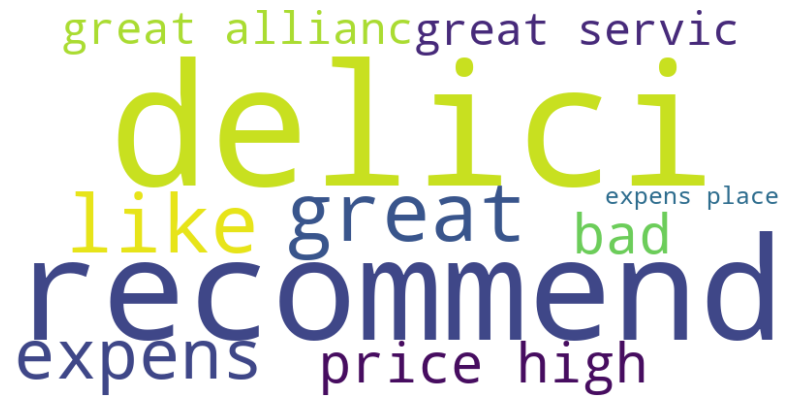

In [14]:
# Step 1: Flatten the list of tokenized words
# Assuming `tokens` is a list of lists of tokens
all_words = [word for token_list in tokens for word in tokens]

# Step 2: Calculate word frequencies
word_freq = Counter(all_words)

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100)
wordcloud.generate_from_frequencies(word_freq)

# Step 4: Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Methord 1 : Lexical Based Analysis
For the first sentiment analysis methord we will be using Vader as a lexical based method for analysing the sentiments. In this code we are creating an instance of the sentiment analyser and then passing our tokens to get a polarity score. Based on the polarity score we will determine the sentiment and return the resulting columns.

In [15]:
db_sentiment = db
lst = []
def sentiment_analysis(sentences):
     
     for sentence in sentences:
      sid_obj = SentimentIntensityAnalyzer()
      sentiment_dict = sid_obj.polarity_scores(sentence)
      sentiment = 'neutral'
      if sentiment_dict['compound'] >= 0.5:
          sentiment = 'positive'
      elif sentiment_dict['compound'] <= -0.5:
          sentiment = 'negative'
      sentiment_dict['sentiment'] = sentiment
      lst.append(sentiment_dict)


sentiment_analysis(tokens)
df_lst = pd.DataFrame(lst)
db_sentiment['pos'] = df_lst['pos']
db_sentiment['neu'] = df_lst['neu']
db_sentiment['neg'] = df_lst['neg']
db_sentiment['compound'] = df_lst['compound']
db_sentiment['sentiment'] = df_lst['sentiment']
db_sentiment.head()

,business_name,author_name,text,photo,rating,rating_category,pos,neu,neg,compound,sentiment
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,we went to palmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,0.168,0.810,0.022,0.7351,positive
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,during my holiday in palmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,0.232,0.730,0.038,0.9299,positive
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,prices are very unfordable the menu in the pho...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,0.209,0.669,0.121,0.2732,neutral
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,turkey cheapest artisans restaurant and its fo...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,0.000,1.000,0.000,0.0000,neutral
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,i dont know what you will look for in terms of...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,0.000,1.000,0.000,0.0000,neutral


Displaying the sentiments calculated

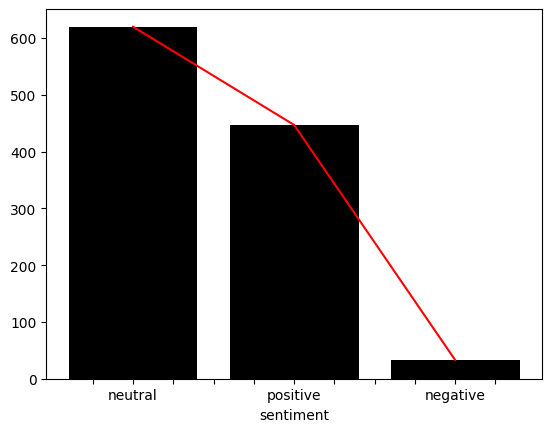

In [16]:
sentiment_grouped_vader = db_sentiment['sentiment'].value_counts()
sentiment_grouped_vader.plot(kind='line', color = 'red')
plot = plt.bar(sentiment_grouped_vader.index, sentiment_grouped_vader, align='center', alpha=1, color='black')

Evaluating the model based on lexical analysis

In [17]:
# preparing to evaluate the model
db_sentiment['sentiment_actual'] = [
   'positive' if rating > 3 else
   'negative' if rating < 3  else
   'neutral'
    for rating in db_sentiment['rating']
]
prediction = db_sentiment['sentiment']
actual = db_sentiment['sentiment_actual']
db_sentiment.head()

,business_name,author_name,text,photo,rating,rating_category,pos,neu,neg,compound,sentiment,sentiment_actual
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,we went to palmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,0.168,0.810,0.022,0.7351,positive,positive
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,during my holiday in palmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,0.232,0.730,0.038,0.9299,positive,positive
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,prices are very unfordable the menu in the pho...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,0.209,0.669,0.121,0.2732,neutral,neutral
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,turkey cheapest artisans restaurant and its fo...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,0.000,1.000,0.000,0.0000,neutral,positive
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,i dont know what you will look for in terms of...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,0.000,1.000,0.000,0.0000,neutral,neutral


In [18]:
cm = confusion_matrix(actual, prediction, labels=['positive', 'negative', 'neutral'])
print(cm)

[[387   4 385]
 [ 15  22 115]
 [ 45   7 120]]


In [19]:
score_precision = precision_score(actual, prediction, average='weighted')
score_f1 = f1_score(actual, prediction, average='weighted')
print(f"The F1 score is: {score_f1}")
print(f"The Precision score is: {score_precision}")

The F1 score is: 0.5267087973886457
The Precision score is: 0.7331478018986137


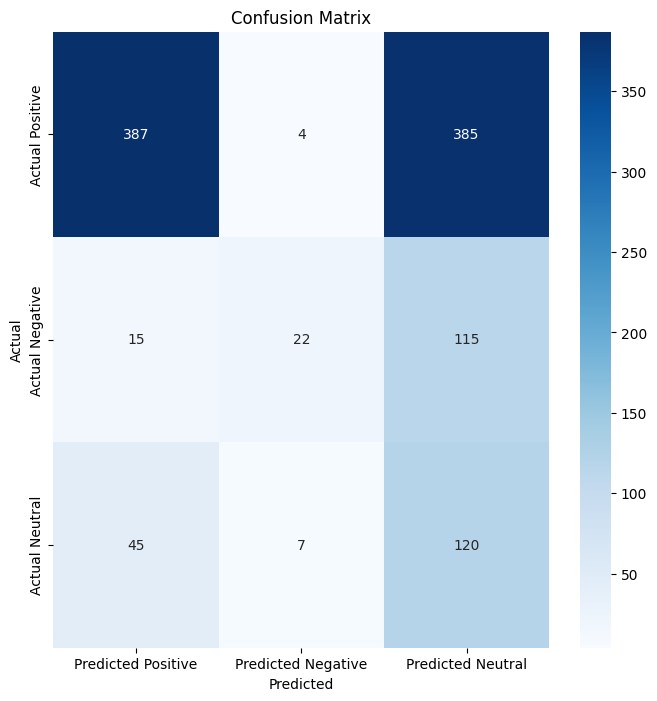

[[387   4 385]
 [ 15  22 115]
 [ 45   7 120]]


In [20]:
cm = confusion_matrix(actual, prediction, labels=['positive', 'negative', 'neutral'])
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative', 'Predicted Neutral'], yticklabels=['Actual Positive', 'Actual Negative', 'Actual Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(cm)

In [21]:
f1 = f1_score(actual, prediction, average='weighted')
print(f"The F1 score is: {f1}")

The F1 score is: 0.5267087973886457


Methord 2: Machine Learning Model
In this methord we will be using Logistic Regression to determine the sentiments. We will be first training the data based on the test data and then will be deploying the model to determine the sentiment.

In [22]:
#Machine Learning Model
db_sentiment.drop(['sentiment'], axis=1, inplace=True)
db_sentiment.drop(['pos'], axis=1, inplace=True)
db_sentiment.drop(['neg'], axis=1, inplace=True)
db_sentiment.drop(['neu'], axis=1, inplace=True)
db_sentiment.drop(['compound'], axis=1, inplace=True)
db_sentiment.drop(['sentiment_actual'], axis=1, inplace=True)
db_sentiment.head()

,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,we went to palmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,during my holiday in palmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,prices are very unfordable the menu in the pho...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,turkey cheapest artisans restaurant and its fo...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,i dont know what you will look for in terms of...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


In [23]:
# Step 1: Convert tokenized lists into strings
# Assuming `tokens` is a list of lists of tokens
text_data = tokens

# Step 2: Vectorize text data with TF-IDF
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
X = tfidf.fit_transform(text_data)

# Step 3: Encode sentiment labels
# Generate sentiment based on ratings (modify as needed)
db['sentiment'] = [
   'positive' if rating > 3 else
   'negative' if rating < 3 else 'neutral'
   for rating in db_sentiment['rating']
]

# Encode labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(db['sentiment'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Step 4: Train Logistic Regression model
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)  # Fit the model

# Make predictions on the test set
preds = lr.predict(X_test)

# If needed, predict on the full dataset and add to `db`
db['predicted_sentiment'] = label_encoder.inverse_transform(lr.predict(X))
print(db[['sentiment', 'predicted_sentiment']].head())

  sentiment predicted_sentiment
0  positive            positive
1  positive            positive
2   neutral            positive
3  positive            positive
4   neutral            positive


Calculating the efficiency of the model

In [24]:
result_ml = db_sentiment['predicted_sentiment']
sentiment_ml = db_sentiment['sentiment']
ps_ml = precision_score(sentiment_ml,result_ml, average='weighted')
f1_ml = f1_score(sentiment_ml,result_ml, average='weighted')
print(f'F1 Score: {f1_ml}')
print(f'Precision Score: {ps_ml}')

F1 Score: 0.6495499340260062
Precision Score: 0.7664089759142094


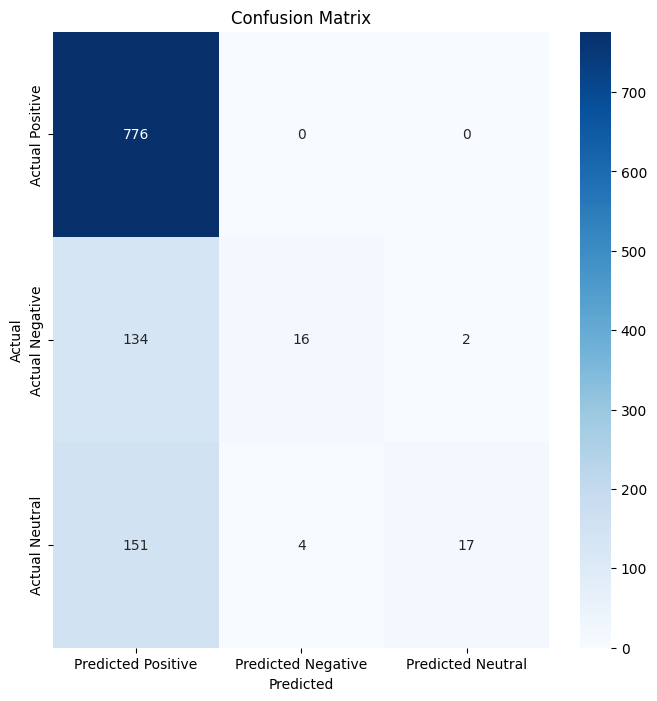

[[776   0   0]
 [134  16   2]
 [151   4  17]]


In [25]:
sentiment_ml = db['sentiment']
result_ml = db['predicted_sentiment']
cm_bert = confusion_matrix(sentiment_ml, result_ml, labels=['positive', 'negative', 'neutral'])
plt.figure(figsize=(8, 8))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative', 'Predicted Neutral'], yticklabels=['Actual Positive', 'Actual Negative', 'Actual Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(cm_bert)

Displaying the result 

<BarContainer object of 3 artists>

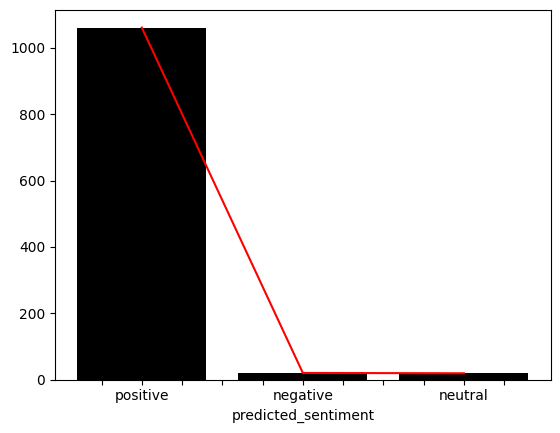

In [26]:
sentiment_values_ml = db_sentiment['predicted_sentiment'].value_counts()
sentiment_values_ml.plot(kind='line', color='red')
plt.bar(sentiment_values_ml.index, sentiment_values_ml, align='center', alpha=1, color='black')

Methord 3: Using a Pre-Trained Model
In this methord we will be using a pre trained model Distilbert which is widely used for analysing sentiments. In this methord we will be training the model on the data and evaluating the sentiments.

In [27]:
# Load models and tokenizers
model_name_d = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name_d)

# Set the configuration to expect 3 classes
config = AutoConfig.from_pretrained(model_name_d, num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained(model_name_d, config=config)

# Map config IDs to sentiment labels
config.id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
config.label2id = {v: k for k, v in config.id2label.items()}  # Ensure bidirectional mapping

# Tokenize text data
tokenized_data = tokenizer(db_sentiment['text'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

# Encode labels
labels = db_sentiment['sentiment'].replace(config.label2id).tolist()

# Create Dataset
train_dataset = Dataset.from_dict({
    'input_ids': tokenized_data['input_ids'],
    'attention_mask': tokenized_data['attention_mask'],
    'labels': labels
})

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    remove_unused_columns=False,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,  # Example: using train data as validation
)

# Train the model
trainer.train()

# Define a function to predict sentiment labels
def sentiment_labels(text):
    tokenized_text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        output = model(input_ids=tokenized_text['input_ids'], attention_mask=tokenized_text['attention_mask'])
    scores = output[0].detach().numpy()[0]
    scores = softmax(scores)
    return config.id2label[np.argmax(scores)]

# Predict on the tokenized list and add to db_sentiment
db_sentiment['result'] = [sentiment_labels(text) for text in db_sentiment['text']]

# Show results
print(db_sentiment[['text', 'sentiment', 'result']])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\apoor\AppData\Local\Temp\ipykernel_34188\3394645868.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels = db_sentiment['sentiment'].replace(config.label2id).tolist()
  5%|▍         | 10/207 [00:41<11:26,  3.49s/it]

{'loss': 1.0396, 'grad_norm': 2.9979465007781982, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.14}


 10%|▉         | 20/207 [01:13<10:12,  3.28s/it]

{'loss': 1.0426, 'grad_norm': 2.00117826461792, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.29}


 14%|█▍        | 30/207 [01:47<09:47,  3.32s/it]

{'loss': 1.0103, 'grad_norm': 2.2235560417175293, 'learning_rate': 3e-06, 'epoch': 0.43}


 19%|█▉        | 40/207 [02:20<09:34,  3.44s/it]

{'loss': 0.9751, 'grad_norm': 2.7592813968658447, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.58}


 24%|██▍       | 50/207 [02:56<09:21,  3.58s/it]

{'loss': 0.9584, 'grad_norm': 1.8401916027069092, 'learning_rate': 5e-06, 'epoch': 0.72}


 29%|██▉       | 60/207 [03:31<08:58,  3.66s/it]

{'loss': 0.9071, 'grad_norm': 2.8712992668151855, 'learning_rate': 6e-06, 'epoch': 0.87}


 34%|███▍      | 70/207 [04:04<07:15,  3.18s/it]

{'loss': 0.7759, 'grad_norm': 2.934616804122925, 'learning_rate': 7.000000000000001e-06, 'epoch': 1.01}


 39%|███▊      | 80/207 [04:37<07:02,  3.32s/it]

{'loss': 0.81, 'grad_norm': 2.0851573944091797, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.16}


 43%|████▎     | 90/207 [05:11<06:40,  3.43s/it]

{'loss': 0.8024, 'grad_norm': 2.0132856369018555, 'learning_rate': 9e-06, 'epoch': 1.3}


 48%|████▊     | 100/207 [05:44<05:58,  3.35s/it]

{'loss': 0.7699, 'grad_norm': 2.931288480758667, 'learning_rate': 1e-05, 'epoch': 1.45}


 53%|█████▎    | 110/207 [06:19<05:46,  3.57s/it]

{'loss': 0.7073, 'grad_norm': 3.183671236038208, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.59}


 58%|█████▊    | 120/207 [06:52<04:48,  3.31s/it]

{'loss': 0.7556, 'grad_norm': 2.273496627807617, 'learning_rate': 1.2e-05, 'epoch': 1.74}


 63%|██████▎   | 130/207 [07:26<04:20,  3.38s/it]

{'loss': 0.5875, 'grad_norm': 1.9191086292266846, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.88}


 68%|██████▊   | 140/207 [08:00<03:44,  3.35s/it]

{'loss': 0.6644, 'grad_norm': 3.9036777019500732, 'learning_rate': 1.4000000000000001e-05, 'epoch': 2.03}


 72%|███████▏  | 150/207 [08:33<03:06,  3.28s/it]

{'loss': 0.5936, 'grad_norm': 2.734523057937622, 'learning_rate': 1.5e-05, 'epoch': 2.17}


 77%|███████▋  | 160/207 [09:06<02:35,  3.32s/it]

{'loss': 0.4963, 'grad_norm': 2.9716880321502686, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.32}


 82%|████████▏ | 170/207 [09:39<02:05,  3.38s/it]

{'loss': 0.5631, 'grad_norm': 7.033340930938721, 'learning_rate': 1.7000000000000003e-05, 'epoch': 2.46}


 87%|████████▋ | 180/207 [10:12<01:35,  3.53s/it]

{'loss': 0.6164, 'grad_norm': 4.184567451477051, 'learning_rate': 1.8e-05, 'epoch': 2.61}


 92%|█████████▏| 190/207 [10:46<00:57,  3.36s/it]

{'loss': 0.4038, 'grad_norm': 2.191840887069702, 'learning_rate': 1.9e-05, 'epoch': 2.75}


 97%|█████████▋| 200/207 [11:21<00:25,  3.60s/it]

{'loss': 0.6227, 'grad_norm': 14.1876859664917, 'learning_rate': 2e-05, 'epoch': 2.9}


100%|██████████| 207/207 [11:46<00:00,  3.41s/it]


{'train_runtime': 706.1137, 'train_samples_per_second': 4.673, 'train_steps_per_second': 0.293, 'train_loss': 0.7439219099312013, 'epoch': 3.0}
                                                   text sentiment    result
0     we went to palmaris with my wife for a holiday...  positive  positive
1     during my holiday in palmaris we ate here to f...  positive  positive
2     prices are very unfordable the menu in the pho...   neutral   neutral
3     turkey cheapest artisans restaurant and its fo...  positive  positive
4     i dont know what you will look for in terms of...   neutral  negative
...                                                 ...       ...       ...
1095  there are so many types of penza you are surpr...  positive  positive
1096  i tried the smoked ribeye penza the dough is t...  positive  positive
1097                        crowded and expensive place   neutral   neutral
1098  no bad it was very crowded there was no lighti...   neutral  negative
1099  excellent penz

Calcualating the efficiency of the model

In [28]:
result_bard = db_sentiment['result']
sentiment_bard = db_sentiment['sentiment']
ps_bert = precision_score(sentiment_bard,result_bard, average='weighted')
f1_bert = f1_score(sentiment_bard,result_bard, average='weighted')
print(f'F1 Score: {f1_bert}')
print(f'Precision Score: {ps_bert}')

F1 Score: 0.822805397559673
Precision Score: 0.8296258179239172


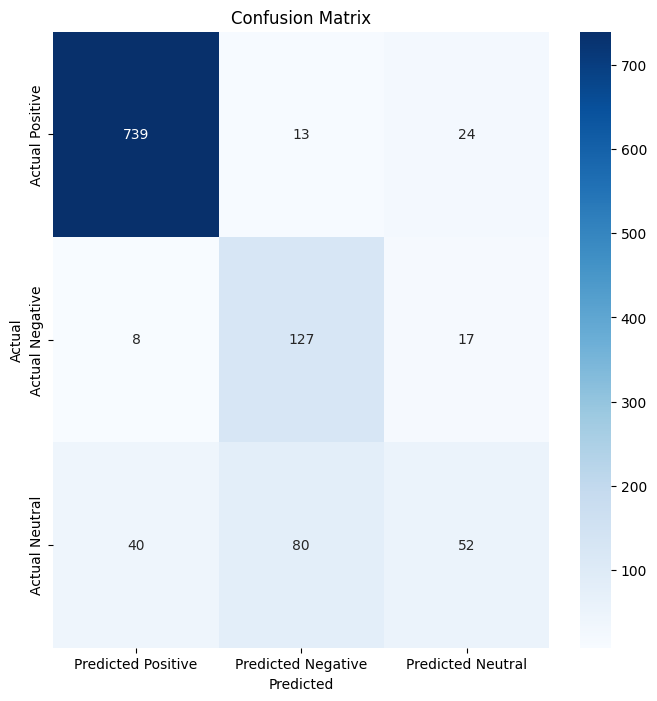

In [29]:
sentiment_bert = db['sentiment']
result_bert = db['result']
cm_bert = confusion_matrix(sentiment_bert, result_bert, labels=['positive', 'negative', 'neutral'])
plt.figure(figsize=(8, 8))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative', 'Predicted Neutral'], yticklabels=['Actual Positive', 'Actual Negative', 'Actual Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Displaying the result

<BarContainer object of 3 artists>

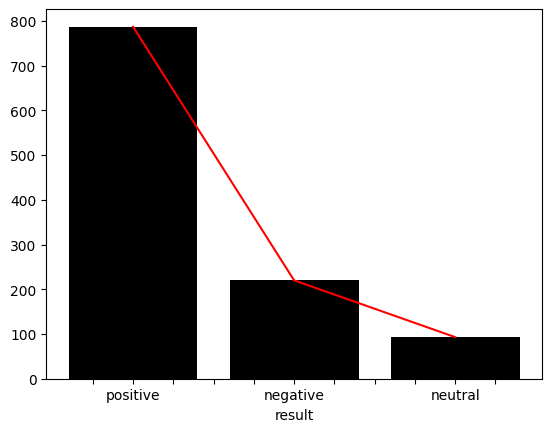

In [30]:
sentiment_values_bert = db_sentiment['result'].value_counts()
sentiment_values_bert.plot(kind='line', color='red')
plt.bar(sentiment_values_bert.index, sentiment_values_bert, align='center', alpha=1, color='black')

**Conclusin:**

This project explored three sentiment analysis methodologies: VADER, Logistic Regression, and DistilBERT evaluating their performance in real-world scenarios. VADER, while efficient and lightweight, struggled with complicated language. Logistic Regression provided a balanced approach with moderate accuracy, while DistilBERT excelled in contextual understanding but at the cost of computational intensity. Comparative analysis demonstrated DistilBERT's superior precision (83.4%), F1 score (80.2%), and contextual adaptability, making it an effective model for applications such as social media sentiment monitoring and customer feedback analysis.
